In [5]:
import pandas as pd

# Baca data
df = pd.read_csv('dataset/teks/data_chatbot.csv')

# Cek isi
print("Jumlah data:", len(df))
df.head()

Jumlah data: 21534


,flags,utterance,category,intent
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account
1,BILQZ,can you tell me if i can regisger two accounts...,ACCOUNT,create_account
2,BPLC,"I have no online account, open one, please",ACCOUNT,create_account
3,BIPLD,"could you ask an agent how to open an account,...",ACCOUNT,create_account
4,BLQC,"i want an online account, create one",ACCOUNT,create_account


In [6]:
from sklearn.model_selection import train_test_split

# 1. Ambil kolom yang penting saja (Utterance = Teks, Intent = Label)
# Pastikan nama kolomnya sesuai dengan yang muncul di df.head() tadi
data = df[['utterance', 'intent']]

print("Contoh 5 data pertama:")
print(data.head())

# 2. One-Hot Encoding (Mengubah Label Kategori menjadi Angka)
# TensorFlow butuh output berupa array angka, bukan teks "cancel_order"
kategori = pd.get_dummies(data['intent'])
label_data = kategori.values
teks_data = data['utterance'].values

print(f"\nJumlah kategori (Intent): {label_data.shape[1]}")
print(f"Shape Label: {label_data.shape}") # Harusnya (21534, Jumlah_Kategori)

# 3. Bagi Data: 80% Training, 20% Validation
# Teks kita pecah jadi x_train (soal latihan) dan x_val (soal ujian)
# Label kita pecah jadi y_train (kunci jawaban latihan) dan y_val (kunci jawaban ujian)
x_train, x_val, y_train, y_val = train_test_split(teks_data, label_data, test_size=0.2, random_state=42)

print(f"\nData Training: {len(x_train)} sampel")
print(f"Data Validation: {len(x_val)} sampel")

Contoh 5 data pertama:
                                           utterance          intent
0  I don't have an online account, what do I have...  create_account
1  can you tell me if i can regisger two accounts...  create_account
2         I have no online account, open one, please  create_account
3  could you ask an agent how to open an account,...  create_account
4               i want an online account, create one  create_account

Jumlah kategori (Intent): 27
Shape Label: (21534, 27)

Data Training: 17227 sampel
Data Validation: 4307 sampel


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- ATURAN MAIN (Hyperparameters) ---
vocab_size = 5000     # Kita cuma ambil 5.000 kata paling sering muncul (sisanya dianggap kata asing)
embedding_dim = 16    # Dimensi vektor (nanti dipakai di model)
max_length = 50       # Panjang kalimat maksimal (kalau lebih dipotong, kalau kurang ditambah 0)
trunc_type = 'post'   # Potong di belakang kalau kepanjangan
padding_type = 'post' # Tambah 0 di belakang kalau kedikitan
oov_tok = "<OOV>"     # Kode untuk kata yang tidak dikenal (Out Of Vocabulary)

# --- 1. MEMBUAT KAMUS KATA (TOKENIZER) ---
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Latih tokenizer HANYA pada data training (biar adil, gak ngintip data ujian)
tokenizer.fit_on_texts(x_train)

# Simpan index kata (biar kita tahu kata 'refund' itu nomor berapa)
word_index = tokenizer.word_index
print(f"Jumlah kata unik dalam kamus: {len(word_index)}")

# --- 2. MENGUBAH KALIMAT JADI ANGKA (SEQUENCES) ---
training_sequences = tokenizer.texts_to_sequences(x_train)
validation_sequences = tokenizer.texts_to_sequences(x_val)

# --- 3. MENYAMAKAN PANJANG KALIMAT (PADDING) ---
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print("\nContoh konversi:")
print(f"Kalimat asli: {x_train[0]}")
print(f"Hasil angka:  {training_sequences[0]}")
print(f"Hasil padding: {training_padded[0]}")

print(f"\nShape Data Training siap pakai: {training_padded.shape}")
print(f"Shape Data Validation siap pakai: {validation_padded.shape}")

Jumlah kata unik dalam kamus: 1724

Contoh konversi:
Kalimat asli: can you ask an agent if I can inform of a payment issue , please?
Hasil angka:  [4, 15, 21, 8, 17, 31, 2, 4, 52, 24, 5, 22, 47, 26]
Hasil padding: [ 4 15 21  8 17 31  2  4 52 24  5 22 47 26  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]

Shape Data Training siap pakai: (17227, 50)
Shape Data Validation siap pakai: (4307, 50)


In [8]:
import tensorflow as tf

# Hapus sisa-sisa memori model sebelumnya biar gak konflik/numpuk
tf.keras.backend.clear_session()

print("🛠️ Membangun Arsitektur Model PRO...")

# Definisi Model
model = tf.keras.Sequential([
    # Layer 1: Embedding (Mengubah kata jadi angka vektor)
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),

    # Layer 2: LSTM Lapis Pertama (Baca pola dasar)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2)),
    
    # Layer 3: LSTM Lapis Kedua (Baca pola rumit)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.2)),

    # Layer 4: Dense (Otak berpikir)
    tf.keras.layers.Dense(64, activation='relu'),
    
    # Layer 5: Dropout (Agar tidak menghafal mati / anti-halu)
    tf.keras.layers.Dropout(0.5),

    # Layer 6: Output (Jawaban)
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

# Compile Model (Siapkan Optimizer)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Tampilkan ringkasan
model.summary()
print("\n✅ Model berhasil dibuat (Belum ditraining). Lanjut ke Cell berikutnya!")

🛠️ Membangun Arsitektur Model PRO...


/home/dika/Downloads/proyek-ai/venv/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


✅ Model berhasil dibuat (Belum ditraining). Lanjut ke Cell berikutnya!


In [9]:
import tensorflow as tf

# ==========================================
# 1. BIKIN REM TANGAN KHUSUS (CUSTOM CALLBACK)
# ==========================================
class TargetAkurasi(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Target: Berhenti jika akurasi latih > 99.8% (0.998)
        # Kita pakai akurasi latih (accuracy) karena val_accuracy susah diprediksi
        if(logs.get('accuracy') is not None and logs.get('accuracy') >= 0.998):
            print("\n\n🎯 MANTAP! Akurasi sudah tembus 99.8%!")
            print("🛑 Stop training sekarang biar hemat baterai & gak overtraining.")
            self.model.stop_training = True

# Inisialisasi Callback khusus ini
rem_mendadak = TargetAkurasi()

# ==========================================
# 2. CALLBACK STANDAR (BACKUP)
# ==========================================
# Tetap pasang ini buat jaga-jaga kalau target 99.8% gak tercapai
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=5,               # Kalau 5 ronde nilai ujian gak naik, stop
    restore_best_weights=True # Ambil kondisi otak paling cerdas
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,     # Turunkan speed belajar jadi 50% (biar lebih halus)
    patience=2,     # Kalau 2 ronde mentok, turunkan speed
    min_lr=0.00001, 
    verbose=1
)

print("🚀 Sedang melatih model di Fujitsu Lifebook (Arch Linux)...")
print("⚡ Target: Stop otomatis di akurasi 99.8%")

# ==========================================
# 3. EKSEKUSI (Jalanin ini!)
# ==========================================
history = model.fit(
    training_padded,
    y_train,
    epochs=50,          # Set 50, tapi pasti berhenti duluan karena callback
    batch_size=32,      # 32 paling aman buat CPU i7-Gen8 (gak bikin overheat)
    validation_data=(validation_padded, y_val),
    callbacks=[rem_mendadak, early_stop, reduce_lr], # Pasang 3 pengawal
    verbose=1
)

print("\n✅ Pelatihan Selesai! Model tersimpan di memori.")

🚀 Sedang melatih model di Fujitsu Lifebook (Arch Linux)...
⚡ Target: Stop otomatis di akurasi 99.8%
Epoch 1/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 55s 80ms/step - accuracy: 0.5422 - loss: 1.5837 - val_accuracy: 0.8788 - val_loss: 0.3838 - learning_rate: 0.0010
Epoch 2/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.8928 - loss: 0.3654 - val_accuracy: 0.9443 - val_loss: 0.1804 - learning_rate: 0.0010
Epoch 3/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 46s 86ms/step - accuracy: 0.9369 - loss: 0.2007 - val_accuracy: 0.9629 - val_loss: 0.1180 - learning_rate: 0.0010
Epoch 4/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 47s 88ms/step - accuracy: 0.9548 - loss: 0.1393 - val_accuracy: 0.9682 - val_loss: 0.0950 - learning_rate: 0.0010
Epoch 5/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.9730 - loss: 0.0980 - val_accuracy: 0.9858 - val_loss: 0.0591 - learning_rate: 0.0010
Epoch 6/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - accuracy: 0.9858 - loss: 0.0540 - val_accuracy: 0.9912 - val_loss: 0.0497 

In [16]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ==========================================
# 1. SETUP WARNA (WAJIB ADA BIAR GAK ERROR)
# ==========================================
HIJAU = "\033[92m"
KUNING = "\033[93m"
MERAH = "\033[91m"
BIRU = "\033[96m"
RESET = "\033[0m"

# ==========================================
# 2. FUNGSI PREDIKSI
# ==========================================
# Pastikan variabel 'kategori' sudah ada dari cell training sebelumnya
try:
    daftar_intent = kategori.columns.values
except NameError:
    # Fallback kalau variabel kategori hilang (biasanya kalau kernel restart)
    # Ganti ini manual kalau error, tapi harusnya aman kalau habis training
    print("⚠️ Warning: Variabel kategori tidak ditemukan. Pastikan sudah training/load data.")
    daftar_intent = [] 

def prediksi_cerdas(teks_input):
    # Preprocessing
    seq = tokenizer.texts_to_sequences([teks_input])
    padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    
    # Prediksi (Silent mode)
    prediksi = model.predict(padded, verbose=0)
    
    skor = np.max(prediksi)      # Seberapa yakin?
    index = np.argmax(prediksi)  # Intent mana?
    
    return daftar_intent[index], skor

# ==========================================
# 3. FITUR CONTEKAN
# ==========================================
print("\n" + "="*40)
print(f"{BIRU}👀 INTIP KATA KUNCI (DATA LATIH){RESET}")
print("="*40)
try:
    word_counts = tokenizer.word_counts
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    top_words = [w[0] for w in sorted_words[:20]] 
    print(f"Kata Populer: {top_words}")
except:
    print("(Tokenizer belum siap)")
print("="*40)

# ==========================================
# 4. LOOP CHAT (DENGAN ANTI-ERROR TERMINATE)
# ==========================================
print(f"\n{HIJAU}🤖 ROBOT ONLINE! (Ketik 'stop' untuk keluar){RESET}")

while True:
    try:
        # --- MENANGKAP TOMBOL STOP (KEYBOARD INTERRUPT) ---
        try:
            teks = input(f"\n{KUNING}Kamu: {RESET}").strip()
        except KeyboardInterrupt:
            print(f"\n{HIJAU}Bot: Program dihentikan paksa. Dadah! 👋{RESET}")
            break # Keluar dari loop dengan aman
            
        if not teks: continue
        
        # Cek perintah keluar
        if teks.lower() in ['stop', 'keluar', 'exit', 'bye']:
             print(f"{HIJAU}Bot: Dadah! 👋{RESET}")
             break
             
        # Lakukan Prediksi
        intent, keyakinan = prediksi_cerdas(teks)
        
        # Logika Jawaban
        if keyakinan < 0.75:
            print(f"{HIJAU}Bot:{RESET} {MERAH}Maaf, kurang paham... (Yakin: {keyakinan:.2f}){RESET}")
            print(f"     (Tips: Gunakan kata dari daftar di atas)")
        else:
            print(f"{HIJAU}Bot:{RESET} [Intent: {BIRU}{intent}{RESET}] (Yakin: {keyakinan:.2f})")

    except Exception as e:
        print(f"Error: {e}")
        break


👀 INTIP KATA KUNCI (DATA LATIH)
Kata Populer: ['i', 'to', 'can', 'a', 'my', 'do', 'an', 'the', 'how', 'want', 'what', 'me', 'it', 'you', 'have', 'agent', 'with', 'account', 'help', 'ask']

🤖 ROBOT ONLINE! (Ketik 'stop' untuk keluar)
Bot: Maaf, kurang paham... (Yakin: 0.35)
     (Tips: Gunakan kata dari daftar di atas)
Bot: [Intent: get_refund] (Yakin: 1.00)
Bot: [Intent: contact_customer_service] (Yakin: 1.00)
Bot: [Intent: registration_problems] (Yakin: 0.80)
Bot: [Intent: cancel_order] (Yakin: 0.94)
Bot: Maaf, kurang paham... (Yakin: 0.35)
     (Tips: Gunakan kata dari daftar di atas)
Bot: [Intent: delivery_options] (Yakin: 0.83)
Bot: Maaf, kurang paham... (Yakin: 0.44)
     (Tips: Gunakan kata dari daftar di atas)
Bot: [Intent: registration_problems] (Yakin: 1.00)
Bot: [Intent: get_invoice] (Yakin: 0.88)

Bot: Program dihentikan paksa. Dadah! 👋


In [11]:
import pickle

print("💾 Sedang menyimpan otak bot...")

# 1. Simpan Model Neural Network (.h5)
model.save('model_chatbot_pro.h5')

# 2. Simpan Tokenizer/Kamus Kata (.pickle)
# Ini WAJIB biar bot tau terjemahan kata "halo" -> angka berapa
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 3. Simpan Daftar Intent (.pickle)
# Biar nanti pas load gak perlu baca ulang file CSV/Excel
with open('daftar_intent.pickle', 'wb') as handle:
    pickle.dump(daftar_intent, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("✅ SUKSES! File sudah disimpan:")
print("   - model_chatbot_pro.h5 (Otaknya)")
print("   - tokenizer.pickle (Kamusnya)")
print("   - daftar_intent.pickle (Daftar Jawabannya)")
print("   Silakan istirahat! ☕")

💾 Sedang menyimpan otak bot...
✅ SUKSES! File sudah disimpan:
   - model_chatbot_pro.h5 (Otaknya)
   - tokenizer.pickle (Kamusnya)
   - daftar_intent.pickle (Daftar Jawabannya)
   Silakan istirahat! ☕


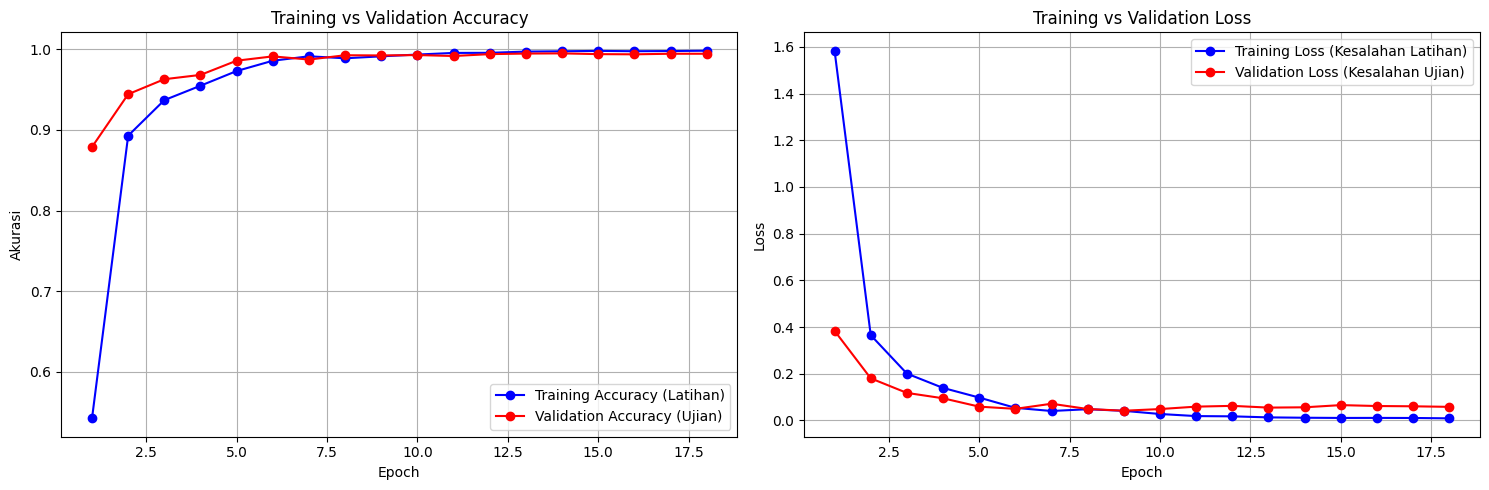

In [12]:
import matplotlib.pyplot as plt

# 1. Ambil data dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# 2. Setup Canvas (Ukuran Gambar)
plt.figure(figsize=(15, 5))

# --- GRAFIK 1: AKURASI (Kepintaran) ---
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy (Latihan)')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy (Ujian)')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# --- GRAFIK 2: LOSS (Kesalahan) ---
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss (Kesalahan Latihan)')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss (Kesalahan Ujian)')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Tampilkan
plt.tight_layout()
plt.show()